In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm

In [2]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__ (self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1)) # Первое место каналы, вторые высота, третье ширина
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
        return {'img': t_img, 'label': t_class_id}

In [3]:
Train_ds_cat_dogs = Dataset2class('C:\DATA\Computer Vision\Cats_vs_dogs\Train\dogs', 
                                  'C:\DATA\Computer Vision\Cats_vs_dogs\Train\cats')

Test_ds_cat_dogs = Dataset2class ('C:\DATA\Computer Vision\Cats_vs_dogs\Test\dogs', 
                                  'C:\DATA\Computer Vision\Cats_vs_dogs\Test\cats')

In [4]:
len(Train_ds_cat_dogs)

8000

In [5]:
len(Test_ds_cat_dogs)

2000

In [6]:
train_loader = torch.utils.data.DataLoader(Train_ds_cat_dogs, 
                                           shuffle=True, 
                                           batch_size=16,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(Test_ds_cat_dogs, 
                                          shuffle=True, 
                                          batch_size=16,
                                          drop_last=False)

In [7]:
model_res_34 = tv.models.resnet34()

In [8]:
model_res_34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        #self.act = nn.GELU()
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)
    
    def forward (self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        #out = self.norm1(out)
        
        #return self.act(x + out)
        return x + out

In [10]:
class BottleneckBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.act = nn.LeakyReLU(0.2)
        
        self.conv0 = nn.Conv2d(nc, nc//4, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(nc//4)
        self.conv1 = nn.Conv2d(nc//4, nc//4, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc//4)
        self.conv2 = nn.Conv2d(nc//4, nc, kernel_size=1, padding=0)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        
        #return self.act(x + out)
        return x + out

In [11]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks, block_type='classic'):
        super().__init__()
        
        truck = []
        for i in range(num_blocks):
            if block_type == 'classic':
                truck += [ResBlock(nc)]
            elif block_type == 'bottleneck':
                truck += [BottleneckBlock(nc)]
            else:
                raise NotImplementedError(f'{block_type} is not implemented')
        self.truck = nn.Sequential(*truck)
        
    def forward(self, x):
        return self.truck(x)

In [12]:
class PsevdoResNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc):
        super().__init__()
        
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.layer1 = ResTruck(nc, 3, block_type='bottleneck')
        self.conv1 = nn.Conv2d(nc, 2*nc, 3, padding=1 ,stride=2)
        self.layer2 = ResTruck(2*nc, 4, block_type='bottleneck')
        self.conv2 = nn.Conv2d(2*nc, 4*nc, 3, padding=1 ,stride=2)
        self.layer3 = ResTruck(4*nc, 6, block_type='bottleneck')
        self.conv3 = nn.Conv2d(4*nc, 4*nc, 3, padding=1 ,stride=2)
        self.layer4 = ResTruck(4*nc, 3, block_type='bottleneck')
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)
        
    def forward (self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        
        return out

In [13]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
model = PsevdoResNet(3, 64, 2)

In [15]:
model

PsevdoResNet(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResTruck(
    (truck): Sequential(
      (0): BottleneckBlock(
        (act): LeakyReLU(negative_slope=0.2)
        (conv0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): BottleneckBlock(
        (act): LeakyReLU(negative_slope=0.2)
        (conv0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [16]:
count_parameters(model)

1685986

In [17]:
for sample in train_loader:
    img = sample['img']
    label = sample['label']
    model(img)
    break

In [18]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [20]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.6
)

In [21]:
loss_fn = loss_fn.to(device)

In [22]:
use_amp = True
scaler = torch.cuda.amp.GradScaler()

In [23]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [24]:
epochs = 12
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']
        label = F.one_hot(label, 2).float()
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        
        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item

        scaler.step(optimizer)
        scaler.update()

        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')
    scheduler.step()
    loss_epochs_list += [loss_val/len(train_loader)]
    acc_epochs_list += [acc_val/len(train_loader)]
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\werng\AppData\Local\Temp\ipykernel_25632\156703249.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.67532	accuracy: 0.562: 100%|█████████████████████████████████████████████████| 500/500 [00:52<00:00,  9.44it/s]


0.7449628058671951
0.574625


loss: 0.59997	accuracy: 0.625: 100%|█████████████████████████████████████████████████| 500/500 [00:50<00:00,  9.93it/s]


0.632070903301239
0.650125


loss: 0.35064	accuracy: 0.875: 100%|█████████████████████████████████████████████████| 500/500 [00:51<00:00,  9.79it/s]


0.5719602579474449
0.69925


loss: 0.51151	accuracy: 0.750: 100%|█████████████████████████████████████████████████| 500/500 [00:50<00:00,  9.93it/s]


0.5077134653329849
0.749


loss: 0.54959	accuracy: 0.688: 100%|█████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.20it/s]


0.44945005095005036
0.78725


loss: 0.47236	accuracy: 0.812: 100%|█████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.06it/s]


0.38792889487743376
0.82475


loss: 0.38085	accuracy: 0.750: 100%|█████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.08it/s]


0.33976762537658217
0.8485


loss: 0.18768	accuracy: 0.875: 100%|█████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.02it/s]


0.2930354464650154
0.86925


loss: 0.25621	accuracy: 0.812: 100%|█████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.08it/s]


0.26108146931231024
0.89


loss: 0.14252	accuracy: 0.938: 100%|█████████████████████████████████████████████████| 500/500 [00:50<00:00,  9.94it/s]


0.23955036118626594
0.901125


loss: 0.28993	accuracy: 0.875: 100%|█████████████████████████████████████████████████| 500/500 [00:50<00:00,  9.95it/s]


0.22108035308122634
0.908


loss: 0.15483	accuracy: 0.938: 100%|█████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.00it/s]

0.20791787135601045
0.916


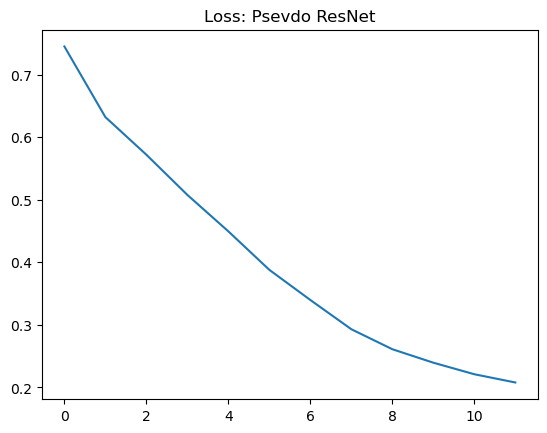

In [25]:
plt.title('Loss: Psevdo ResNet')
plt.plot(loss_epochs_list);

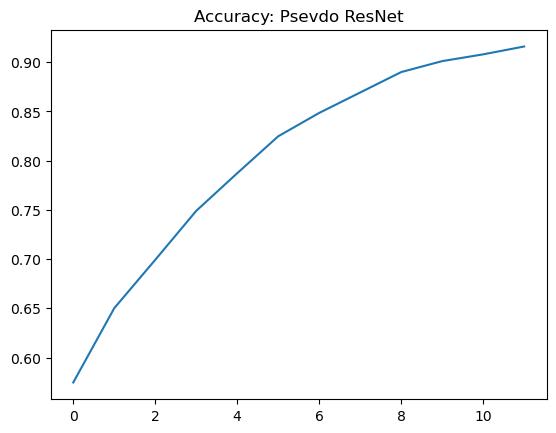

In [26]:
plt.title('Accuracy: Psevdo ResNet')
plt.plot(acc_epochs_list);